In [1]:
import warnings;
warnings.simplefilter('ignore')

In [2]:
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep
import orca
import os; os.chdir('/home/juan/ual_model_workspace/spring-2019-models')#('../')
from statsmodels.discrete.discrete_model import MNLogit
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import tree
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
from collections import OrderedDict

from urbansim_templates.models import SmallMultinomialLogitStep
import seaborn as sns

from scripts import datasources
from scripts import variables
# from scripts import utils
from scripts import models
# from scripts import datasources, models, variables

/home/juan/anaconda3/envs/template-env/lib/python3.6/site-packages/pandana/network.py:5: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/juan/anaconda3/envs/template-env/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/juan/anaconda3/envs/template-env/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/juan/anaconda3/envs/template-env/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/juan/anaconda3/envs/template-env/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/juan/anaconda

Registering model step 'auto_ownership'
Registering model step 'TOD_choice'
Registering model step 'primary_mode_choice'
Registering model step 'WLCM'


In [3]:
# from scripts import datasources, models, variables, utils

In [4]:
from urbansim_templates import modelmanager as mm

In [20]:
# os.listdir("/home/juan/ual_model_workspace/configs/")

In [5]:
mm.initialize(path = '/home/juan/ual_model_workspace/spring-2019-models/configs')

# ual_model_workspace/spring-2019-models/configs

Registering model step 'auto_ownership'
Registering model step 'TOD_choice'
Registering model step 'primary_mode_choice'
Registering model step 'WLCM'


In [6]:
os.getcwd()

'/home/juan/ual_model_workspace/spring-2019-models'

## Generating accesibility variables

In [7]:
orca.run(['initialize_network_small', 'network_aggregations_small'])

orca.run(['initialize_network_walk', 'network_aggregations_walk'])

print()

Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 0.00 s
Running step 'network_aggregations_small'
Computing accessibility variables
Computing units_10000
Computing units_sf_10000
Computing units_mf_10000
Computing pop_10000
Computing hh_10000
Computing poor_10000
Computing renters_10000
Computing avg_income_10000
Computing jobs_10000
Computing avg_rent_10000
Computing med_rent_10000
Computing pop_white_10000
Computing pop_black_10000
Computing pop_asian_10000
Computing pop_hisp_10000
Computing units_25000
Computing units_sf_25000
Computing units_mf_25000
Computing pop_25000
Computing hh_25000
Computing poor_25000
Computing renters_25000
Computing avg_income_25000
Computing jobs_25000
Computing avg_rent_25000
Computing pop_white_25000
Computing pop_black_25000
Computing pop_asian_25000
Computing pop_hisp_25000
Computing jobs_10000_retail
Computing jobs_25000_retail
Computing jobs_10000_fire
Computing jobs_25000_fire
Computing jobs_10000_tech
Compu

### Some additional functions

In [8]:
def normalize(data):
    ''' 
    Normalizes values in a Series
    Input: 
    data: Series-like
    
    Return: Normalized Series-like object
    '''
    if data.dtype == 'O':
        return 0
    else:
        return (data - np.mean(data)) / np.std(data)

## Loading data

In [9]:
#Loading am peak transit accessibility varaibles
@orca.table(cache=False)
def am_acc():
    df = pd.read_csv('/home/data/urbanaccess_transit/access_indicators_ampeak.csv',dtype = {'block_id':str})
    df.block_id = df.block_id.str.zfill(15)
    return df

households = orca.get_table('households').to_frame()
# persons = orca.get_table('persons').to_frame()
persons = pd.read_csv('/home/data/spring_2019/2025/persons.csv', 
                      index_col='member_id', dtype={'member_id': int, 'household_id': int})

parcels = orca.get_table('parcels').to_frame()
nodessmall = orca.get_table('nodessmall').to_frame()
# nodessmall = pd.read_csv('/home/data/2018-07/nodessmall_vars.csv')
nodessmall.index.name = 'node_id_small'
nodeswalk = orca.get_table('nodeswalk').to_frame()
# nodeswalk = pd.read_csv('/home/data/2018-07/nodeswalk_vars.csv')
nodeswalk.index.name = 'node_id_walk'
am_acc = orca.get_table('am_acc').to_frame()

In [10]:


persons = pd.read_csv('/home/data/spring_2019/2025/persons.csv',) 
#                       index_col='member_id', dtype={'member_id': int, 'household_id': int})
persons.head()

,Unnamed: 0,student,household_id,age,primary_commute_mode,worker,work_at_home,sex,hours,hispanic,race_id,member_id,edu,relate,earning
0,0,0,0,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0
1,1,0,670,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0
2,2,0,740,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0
3,3,0,975,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0
4,4,0,977,47,1.0,1,0,1,40.0,1,1,1,22.0,0,85000.0


In [11]:
#Creating a Parcel Table with accessibility variables 

# Merging transit accessibility to parcels (Have to do this manually because orca.merge_tables performs inner merge only)
parcels_acc = parcels.reset_index().merge(am_acc, how='left', on='block_id').set_index('parcel_id')

#Filling transit accessibility NA with median value and adding columns to the parcelDataFrame in orca
for acc_col in set(parcels_acc.columns) - set(parcels):
    parcels_acc[acc_col].fillna(parcels_acc[acc_col].median())

parcels_acc = parcels_acc.reset_index().merge(nodessmall, 
                                          how='left', 
                                          left_on='node_id_small',
                                          right_index= True).set_index('parcel_id')

parcels_acc = parcels_acc.reset_index().merge(nodeswalk, 
                                          how='left', 
                                          left_on='node_id_walk',
                                          right_index= True).set_index('parcel_id')



## Merging process

### Synthetic population

In [13]:
parcels_with_acc = parcels.reset_index().merge(am_acc, how='left', on='block_id').set_index('primary_id')
parcels_with_acc.head()

,parcel_id,proportion_undevelopable,development_type_id,parcel_id_local,block_id,acres,geom_id,shape_area,apn,tax_exempt_status,...,average_income_20,below_jobs_20,below_jobs_40,below_jobs_60,employment_20,employment_40,employment_60,population_20,population_40,population_60
0,229116,0.0,1,,060014511022061,3.360520,10305106092872,1.359956e+04,099 029001700,0,...,11909.593750,2911.103516,6.954954e+05,1.261719e+06,3977.569580,9.196619e+05,1.643289e+06,1.161895e+04,1.523784e+06,3.083880e+06
1,244166,0.0,1,,060014511011025,1.294423,11107351665227,5.238348e+03,099B540210200,0,...,15186.344727,2894.846680,5.774668e+05,1.173576e+06,3175.333496,7.665082e+05,1.530112e+06,1.119106e+04,1.223592e+06,2.848800e+06
2,202378,0.0,25,,060014351031029,14.993605,11030175960628,6.067702e+04,085A643106000,1,...,19240.576172,106.014801,1.073881e+05,7.683527e+05,109.150246,1.485545e+05,1.003674e+06,6.511355e+02,1.764887e+05,1.794940e+06
3,2004420,0.0,-1,,060971541003180,316.247146,6381677629073,1.279808e+06,141-100-012,0,...,24899.277344,8.183801,2.591878e+02,7.835066e+03,8.183801,2.647908e+02,9.493087e+03,1.850755e+01,3.618403e+02,1.231156e+04
4,340332,0.0,2,,060014419272014,0.621275,314875459798,2.514215e+03,525 166004800,0,...,15905.204102,537069.875000,1.390428e+06,1.749340e+06,722645.125000,1.813563e+06,2.267568e+06,1.004974e+06,3.299243e+06,4.365044e+06


In [14]:
# Merging transit accessibility to parcels 
#(Have to do this manually because orca.merge_tables performs inner merge only)
parcels_with_acc = parcels.reset_index().merge(am_acc, how='left', on='block_id').set_index('parcel_id')

#Filling transit accessibility NA with median value and adding columns to the parcelDataFrame in orca
for acc_col in set(parcels_with_acc.columns) - set(parcels):
    orca.add_column('parcels',acc_col,
         parcels_with_acc[acc_col].fillna(parcels_with_acc[acc_col].median())
                   )

#Merging parcel to househols
@orca.table(cache=False)
def hh_merged():
    df = orca.merge_tables(target = 'households',tables = ['households','units','buildings','parcels'])
    return df

#Uploading merge df
hh_merged = orca.get_table('hh_merged').to_frame()

#Merging nodessmall and nodeswalk to household
hh_merged = hh_merged.merge(nodessmall, how = 'left', left_on = 'node_id_small', right_index= True
                           ).merge(nodeswalk, how = 'left', left_on = 'node_id_walk', right_index= True )

#Generating household variables from the persons table 
hh_16_younger = persons[persons['age'] < 16].groupby(by='household_id').agg({'age':'count'}).rename(columns={'age': 'hh_16_younger'})
hh_70_older = persons[persons['age'] > 70].groupby(by='household_id').agg({'age':'count'}).rename(columns={'age': 'hh_70_older'})
hh_students = persons[persons['student'] == 1].groupby(by='household_id').agg({'student':'count'}).rename(columns={'student': 'hh_student'})
hh_work_home = persons[persons['work_at_home'] == 1].groupby(by='household_id').agg({'work_at_home':'count'}).rename(columns={'work_at_home': 'hh_work_home'})

# Merging variables to hh_merged
hh_merged = hh_merged .merge(hh_16_younger, on = 'household_id', how = 'left'
                           ).merge(hh_70_older, on ='household_id', how = 'left'
                                  ).merge(hh_students, on= 'household_id',how = 'left'
                                         ).merge(hh_work_home, on= 'household_id', how = 'left')

# Filling NA with zeros 
values = {'hh_16_younger': 0, 'hh_70_older': 0, 'hh_student': 0, 'hh_work_home': 0}
hh_merged = hh_merged.fillna(value=values)


#Filter repited values is any
filter_col = [col for col in hh_merged if (col.endswith('_y')) | (col.endswith('_x'))]

if len(filter_col) != 0:
    hh_merged = hh_merged.drop(columns=filter_col)

In [ ]:
# Additional Jayne's code for MNL 
# # income bins
# income_bins = pd.cut(orca.get_table('households').to_frame().income,
#       bins = [0,20000,40000,60000,80000,100000,120000,np.inf],
#       labels = ['2','4','6','8','10','12','12p'],include_lowest = True)
# income_bin_dummies = pd.get_dummies(income_bins,prefix = 'income')
# for i in income_bin_dummies.columns:
#     orca.add_column('households',i,income_bin_dummies[i])

# # tenure type dummy
# orca.add_column('households','tenure_1',(orca.get_table('households').to_frame()['tenure']==1).astype(int))
# orca.add_column('households','tenure_2',(orca.get_table('households').to_frame()['tenure']==2).astype(int))
# orca.add_column('households','tenure_3',(orca.get_table('households').to_frame()['tenure']==3).astype(int))
# orca.add_column('households','tenure_4',(orca.get_table('households').to_frame()['tenure']==4).astype(int))

# # single family as integer
# orca.add_column('households','single_family_int',(orca.get_table('households').to_frame()['single_family'].astype(int)))

# # building type dummy
# orca.add_column('households','building_type_2',(orca.get_table('households').to_frame()['building_type']==2).astype(int))

# county_dummies = pd.get_dummies(parcels['county_id'].astype(int),prefix='county')
# for i in county_dummies.columns:
#     orca.add_column('parcels',i,county_dummies[i])

# acc_cols = list(orca.get_table('nodessmall').to_frame().columns) + list(orca.get_table('nodeswalk').to_frame().columns) + list(set(parcels_with_acc.columns) - set(parcels))

### CHTS data

In [197]:
persons_chts = pd.read_csv('/home/data/fall_2018/chts_persons_w_zone_ids.csv')
household_chts = pd.read_csv("/home/data/fall_2018/CHTS_csv_format/data/Deliv_HH.csv")

In [198]:
# Variables in the persons table
# persons_chts['worker'] = [1 if x == 1 else 0 for x in persons_chts['EMPLY']]
persons_chts['children'] = [1 if x < 18 else 0 for x in persons_chts.AGE]
persons_chts['TransitPass'] = persons_chts.TRANS.apply(lambda x: 1 if x == 1 else 0)

#Age categories 
persons_chts['age_0_15'] = [1 if x < 16 else 0 for x in persons_chts.AGE]
persons_chts['age_16_17'] = [1 if (x >= 16) & (x <=17) else 0 for x in persons_chts.AGE]
persons_chts['age_18_25'] = [1 if (x >= 18) & (x <=23) else 0 for x in persons_chts.AGE]
persons_chts['age_25_40'] = [1 if (x >= 24) & (x <=38) else 0 for x in persons_chts.AGE]
persons_chts['age_40_60'] = [1 if (x >= 39) & (x <=60) else 0 for x in persons_chts.AGE]
persons_chts['age_60'] = [1 if x > 60 else 0 for x in persons_chts.AGE]

#Occupation Categories 
persons_chts['worker_student'] = [1 if (persons_chts.EMPLY[x] == 1) & (persons_chts.STUDE[x] <=2) else 0 for x in range(len(persons_chts.EMPLY))]
persons_chts['non_worker_non_student'] = [1 if (persons_chts.EMPLY[x] != 1) & (persons_chts.STUDE[x] > 2) else 0 for x in range(len(persons_chts.EMPLY))]
persons_chts['worker'] = [1 if (persons_chts.EMPLY[x] == 1) & (persons_chts.worker_student[x] != 1) else 0 for x in range(len(persons_chts.EMPLY))]
persons_chts['student'] = [1 if (persons_chts.STUDE[x] <= 2) & (persons_chts.worker_student[x] != 1) else 0 for x in range(len(persons_chts.EMPLY))]


# #Creating person-based variables to merge onto Household table
person_var = persons_chts.groupby(by ='SAMPN').agg({'PERNO': 'count',
                                                    'AGE': 'max',
                                                    'zone_id_home': 'first',
                                                    'EMPLY':'sum', 
                                                    'children':'sum',
                                                    'TransitPass':'sum',
                                                    'parcel_id_home': 'first',
                                                    'age_0_15': 'sum',
                                                    'age_16_17': 'sum',
                                                    'age_18_25': 'sum',
                                                    'age_25_40': 'sum',
                                                    'age_40_60': 'sum',
                                                    'age_60': 'sum', 
                                                    'non_worker_non_student': 'sum',
                                                    'worker_student':'sum',
                                                    'worker': 'sum',
                                                    'student': 'sum'})

household_chts = household_chts.merge(person_var, how = 'left', left_on = 'SAMPN', right_index=True )
household_chts = household_chts.dropna(subset=['PERNO', 'AGE', 'zone_id_home', 'children'])
household_chts['max_35'] = [1 if x <=35 else 0 for x in household_chts.AGE]

#Creating a Parcel Table with accessibility variables 
# Merging transit accessibility to parcels (Have to do this manually because orca.merge_tables performs inner merge only)
parcels_acc = parcels.reset_index().merge(am_acc, how='left', on='block_id').set_index('parcel_id')

#Filling transit accessibility NA 
for acc_col in set(parcels_acc.columns) - set(parcels):
    parcels_acc[acc_col].fillna(parcels_acc[acc_col].median())

parcels_acc = parcels_acc.reset_index().merge(nodessmall, 
                                          how='left', 
                                          left_on='node_id_small',
                                          right_index= True).set_index('parcel_id')

parcels_acc = parcels_acc.reset_index().merge(nodeswalk, 
                                          how='left', 
                                          left_on='node_id_walk',
                                          right_index= True).set_index('parcel_id')


#Merging parcels onto household
df_merge = household_chts.merge(parcels_acc, how = 'left', left_on ='parcel_id_home', right_index= True )

df_merge = df_merge[df_merge.INCOM<50]

In [199]:
df_merge['cars_alt'] = df_merge['HHVEH'].apply(lambda x: 0*(x==0)+ 1*(x==1)+ 2*(x==2)+3*(x>=3))
df_merge['RESTY'] = [1 if (x>=4) & (x<=6) else 0 for x in df_merge.RESTY]
df_merge['single_family'] = [1 if x >= 1 else 0 for x in df_merge.HHSIZ]

In [200]:
# df_merge.isnull().sum()

In [201]:
# sns.catplot(x = 'cars_alt', kind="count", palette="ch:.25", data=df_merge)
# plt.xlabel('Number of cars per household')
# plt.ylabel('Households');

In [202]:
#Getting variables names for each data source
accessibility_var = set(parcels_acc) - set(parcels)
parcel_var = set(parcels.columns) - set(accessibility_var)
households_var_continious = ['INCOM','AGE', 'children', 'TransitPass'] # ,'PERNO', 'EMPLY'                   
households_var_dummy = ['max_35', 'age_0_15', 
                    'age_16_17', 'age_18_25', 'age_25_40','age_40_60',
                    'age_60', 'worker_student', 'non_worker_non_student',
                   'worker','student','RESTY', 'TEN']#, 'HHLIC', ]
dependent_var = ['cars_alt']

In [203]:
final_var = list(accessibility_var) + households_var_continious + households_var_dummy + dependent_var

#Creating a dataset with varaibles needed
df = df_merge.loc[:,final_var]

## Machine Learning approach

In [24]:
df_ml = df_merge.loc[:,final_var]

to_normalize =  households_var_continious + list(accessibility_var) 

for i in to_normalize:
    df_ml[i] = normalize(df_ml[i])

df_ml = df_ml.dropna(axis=1)

## EDA CHTS data

In [25]:
#Splitting the data
x = df_ml.drop(['cars_alt'], axis = 1)
y = df_ml.loc[:,'cars_alt']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state= 2348)

### Decission tree

In [26]:
result_train = []
result_test = []
max_depth = range(1,20)
for i in max_depth:
    clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=i)
    scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
    result_train.append(scores['train_score'].mean())
    result_test.append(scores['test_score'].mean()) 


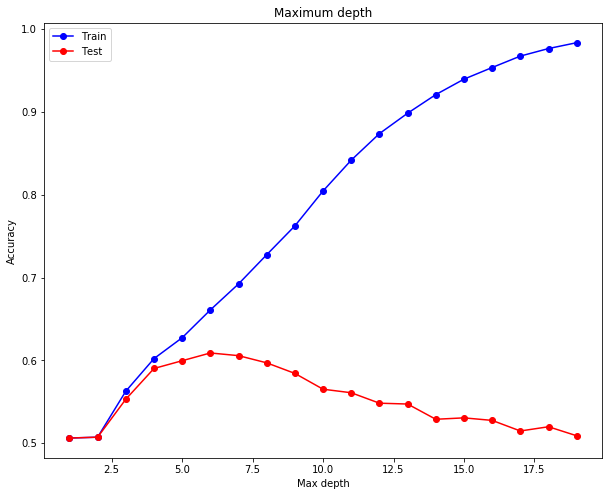

In [27]:
plt.figure(figsize = (10,8))
plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
plt.plot(max_depth, result_test, '-o',color='red',label='Test')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.title('Maximum depth')
plt.legend();

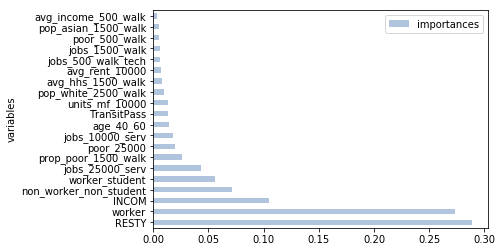

In [28]:
clf = tree.DecisionTreeClassifier(criterion='entropy', splitter = 'best', 
                                  max_depth= 5, class_weight ={0: 1, 1: 1})#, 
#                                   min_weight_fraction_leaf = 0.2 )
clf.fit(X_train, y_train)

aa = pd.DataFrame({'importances':clf.feature_importances_,
                   'variables':X_train.columns}).sort_values(by = 'importances', ascending= False)

aa[:20].plot.barh(x = 'variables', y='importances', color ='lightsteelblue')#, figsize =(15,5) )
plt.yticks();#(fontsize = 10)
# plt.tight_layout()

Text(0.5,1,'Feature importance - Decision Tree')

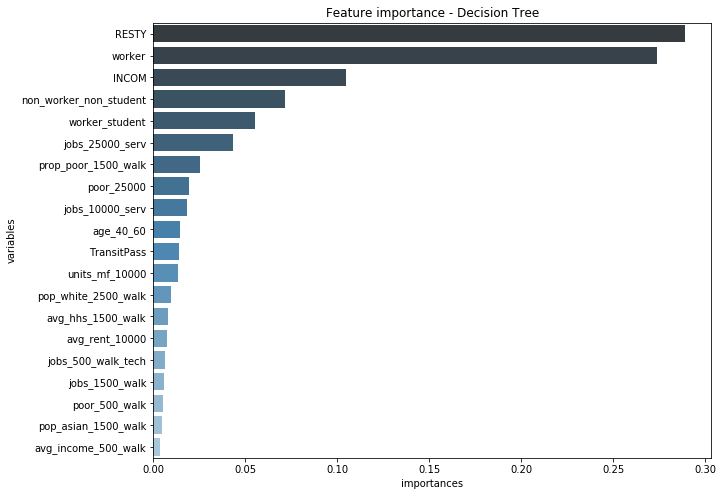

In [29]:
plt.figure(figsize = (10,8))
ax = sns.barplot(x='importances', y='variables', data=aa[:20],palette="Blues_d" )
plt.title('Feature importance - Decision Tree')

In [30]:
pd.crosstab( y_test, clf.predict(X_test))#,normalize = 'index')

col_0,0,1,2,3
cars_alt,,,,
0,81,93,18,1
1,70,541,248,1
2,12,225,1007,30
3,1,51,391,121


In [31]:
clf.score(X_test, y_test)

0.6053268765133172

In [32]:
y_test.shape

(2891,)

### Gradient Boosting

In [33]:
model = GradientBoostingClassifier(max_depth=3, n_estimators=100)
model.fit(X_train, y_train)
importances = model.feature_importances_
pd.crosstab( y_test, model.predict(X_test))
model.score(X_test, y_test)

0.6413005880318229

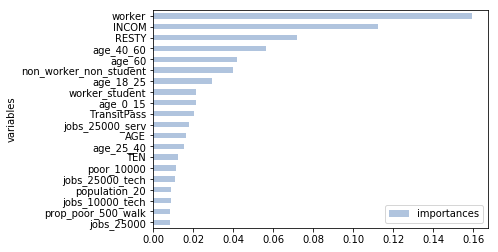

In [34]:
bb = pd.DataFrame({'importances':model.feature_importances_,
                   'variables':X_train.columns}).sort_values(by = 'importances', ascending= True)

bb[-20:].plot.barh(x = 'variables', y='importances', color ='lightsteelblue')#, figsize =(15,5) )
plt.yticks();#(fontsize = 10)

In [35]:
pd.crosstab( y_test, model.predict(X_test))

col_0,0,1,2,3
cars_alt,,,,
0,72,109,12,0
1,34,575,242,9
2,10,188,1004,72
3,2,38,321,203


In [36]:
model.score(X_test, y_test)

0.6413005880318229

## MLN model

*Select the fetures that are greater than the feature importances mean*

In [209]:
df_mnl = df[list(bb[bb.importances>bb.importances.mean()].variables)]
df_mnl['cars_alt'] = df['cars_alt']

In [210]:
continous_var = ['jobs_10000_serv', 'sqft_unit_500_walk', 'prop_singles_1500_walk',
                 'avg_hhs_1500_walk', 'jobs_25000', 'prop_poor_500_walk','jobs_10000_tech', 
                 'population_20', 'jobs_25000_tech', 'poor_10000']

dumy_var = ['TransitPass', 'age_0_15','worker_student', 'age_18_25', 'non_worker_non_student', 
            'age_60', 'age_40_60', 'RESTY', 'INCOM', 'worker']

dependet_variable = ['cars_alt']

In [211]:
#Creates 3 dummies for income
#df_mnl['income_0_50k'] = [1 if x<=4 else 0 for x in df_mnl.INCOM]
df_mnl['income_50K_150k'] = [1 if (x>4) & (x<=7) else 0 for x in df_mnl.INCOM]
df_mnl['income_+150K'] = [1 if x>=8 else 0 for x in df_mnl.INCOM]
df_mnl.drop(['INCOM'], axis = 1, inplace = True)

#Creating an intercept
df_mnl['intercept'] = np.ones(df_mnl.shape[0])

In [212]:
#Splitting the data


# x = df_mnl.loc[:,['intercept', 'income_0_50k','income_50K_150k', 'worker','RESTY', 
#                'age_18_25','age_25_40','age_40_60','age_60', 'TransitPass', 'non_worker_non_student',
#                'TEN', 'jobs_25000_serv','poor_10000','population_20','jobs_25000_tech','jobs_10000_tech',
#                   'units_mf_10000', 'avg_income_1500_walk']]
               
#                'units_mf_10000', 'avg_income_1500_walk', 'avg_hhs_1500_walk',
#        'prop_poor_500_walk', 'prop_singles_1500_walk', 'jobs_25000',
#        'jobs_10000_tech', 'jobs_25000_tech', 'population_20', 'poor_10000',
#        'TEN', 'age_25_40', 'AGE', 'jobs_25000_serv', 'TransitPass', 'age_0_15',
#        'worker_student', 'age_18_25', 'non_worker_non_student', 'age_60',
#        'age_40_60', 'RESTY', ]

x = df_mnl.drop(['cars_alt'], axis = 1)
y = df_mnl.loc[:,'cars_alt']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state= 2348)

In [214]:


@orca.injectable(autocall=False)
def COM(y, x):
    model = MNLogit(y_train, X_train)
    result = model.fit()
    return result


# result.summary()

In [215]:
orca.get_injectable('COM')(y_train, X_train).summary().add_table_params

Optimization terminated successfully.
         Current function value: 0.831409
         Iterations 8


<bound method Summary.add_table_params of <class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
Dep. Variable:               cars_alt   No. Observations:                 5867
Model:                        MNLogit   Df Residuals:                     5789
Method:                           MLE   Df Model:                           75
Date:                Tue, 18 Jun 2019   Pseudo R-squ.:                  0.3156
Time:                        15:30:35   Log-Likelihood:                -4877.9
converged:                       True   LL-Null:                       -7127.1
                                        LLR p-value:                     0.000
            cars_alt=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
jobs_10000_serv        -4.403e-06   2.91e-05     -0.151      0.880   -6.14e-05    5.26e-05
sqft_

In [128]:
#Prediction
mnl_result = result.predict(X_train)
mnl_result['predicted'] = mnl_result.idxmax(axis=1, skipna=True)

#Cross tab
pd.crosstab( y_train, mnl_result['predicted'], normalize= 'index').round(decimals=3)

predicted,0,1,2,3
cars_alt,,,,
0,0.326,0.588,0.084,0.002
1,0.031,0.680,0.279,0.010
2,0.003,0.133,0.810,0.054
3,0.002,0.050,0.584,0.364


In [129]:
a = pd.crosstab( y_train, mnl_result['predicted'])
a

predicted,0,1,2,3
cars_alt,,,,
0,132,238,34,1
1,57,1240,508,18
2,7,345,2108,141
3,2,52,606,378


In [130]:
accuracy = np.sum(np.diagonal(np.array(a)))/y_train.shape[0]
accuracy

0.6575762740753366

In [150]:
df = pd.DataFrame({'B': [1,1,1,1,1,1,1], 
                   'C': [1,2,3,1,2,3,1]})
orca.add_table('x_matrix', df)

In [168]:


orca.add_table('x_matrix', df_mnl)

In [180]:
m = SmallMultinomialLogitStep()
m.name = 'car_ownership_model'
m.tables = ['x_matrix']
m.choice_column = 'cars_alt'
m.model_expression = OrderedDict([('intercept', [0,1,2])])

In [181]:
m.fit()

Log-likelihood at zero: -7,861.6695
Initial Log-likelihood: -7,861.6695
Estimation Time for Point Estimation: 0.20 seconds.
Final log-likelihood: -6,585.6830
                     Multinomial Logit Model Regression Results                    
Dep. Variable:                     _chosen   No. Observations:                8,758
Model:             Multinomial Logit Model   Df Residuals:                    8,755
Method:                                MLE   Df Model:                            3
Date:                     Tue, 18 Jun 2019   Pseudo R-squ.:                   0.162
Time:                             14:59:31   Pseudo R-bar-squ.:               0.162
AIC:                            13,177.366   Log-Likelihood:             -6,585.683
BIC:                            13,198.599   LL-Null:                    -7,861.670
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept_

In [183]:
from statsmodels.discrete.discrete_model import MNLogit
model = MNLogit(df_mnl.loc[:,['cars_alt']], df_mnl.loc[:,['intercept']])
result = model.fit()
result.summary().add_table_params

Optimization terminated successfully.
         Current function value: 1.217206
         Iterations 6


<bound method Summary.add_table_params of <class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
Dep. Variable:               cars_alt   No. Observations:                 8758
Model:                        MNLogit   Df Residuals:                     8755
Method:                           MLE   Df Model:                            0
Date:                Tue, 18 Jun 2019   Pseudo R-squ.:               4.161e-11
Time:                        15:13:26   Log-Likelihood:                -10660.
converged:                       True   LL-Null:                       -10660.
                                        LLR p-value:                       nan
cars_alt=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.5011      0.045     33.195      0.000       1.412       1.590
-----------------------------------------